In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import OrderedDict

def symbol_to_path(symbol, base_dir="AdjDaily"):
    """Return CSV file path given ticker symbol."""
    return os.path.join(base_dir, "{}.csv".format(str(symbol)))

def get_data(symbols, dates,col):
    """Read stock data (adjusted close) for given symbols from CSV files."""
    df = pd.DataFrame(index=dates)
    if 'TASI' not in symbols:  # add SPY for reference, if absent
        symbols.insert(0, 'TASI')
    dateparse = lambda x: pd.datetime.strptime(x, '%d/%m/%Y')
    for symbol in symbols:
        df_temp = pd.read_csv(symbol_to_path(symbol), index_col='Date',
                parse_dates=['Date'],date_parser=dateparse, usecols=['Date', col ], na_values=['nan'])
        df_temp = df_temp.rename(columns={col: symbol})
        df = df.join(df_temp)

        if symbol == 'TASI':  # drop dates SPY did not trad
            df = df.dropna(subset=["TASI"])

    return df

def load_df():
    dates = pd.date_range('01/01/2002', '01/01/2017')
    N= (dates[-1]-dates[0])/365
    N = str(N).split()[0]
    files = os.listdir("AdjDaily")
    symbols=[]
    for name in files:
        if name[0].isdigit():
            symbols.append(name.split('.')[0])
    df = get_data(symbols, dates, 'Close')
    df.to_pickle('database.pkl')
    return df
def normalize_data(df):
    return df/df.iloc[0,:]

def compute_daily_returns(df):
    daily_returns = (df/df.shift(1))-1
    daily_returns = daily_returns[1:]
    return daily_returns

def stats(df,period):
    if period == 'W':
        p = 52.0
    if period == 'M':
        p = 12.0
    if period == 'D':
        p = 365.0
    cagr = (df.iloc[-1]/df.iloc[0])**(1.0/(len(df)/p)) - 1.0
    dr = compute_daily_returns(df)
    sharpe = np.sqrt(p) * dr.mean() / dr.std()
    print (' CAGR(%) = ' + str(cagr * 100))
    print (' Sharpe ratio = ' + str(sharpe))

def multi_period_return(period_returns):
    return np.prod(period_returns + 1) - 1

def pos_val(df,capital=100000,alloc=[]):
    if alloc == []:
        alloc= 1.0/len(df.columns)
    return (normalize_data(df) * alloc * capital).sum(axis=1)

# This function creates chunks and returns them
def chunkify(lst,n):
    return [ lst[i::n] for i in np.arange(n) ]

In [122]:
try:
    df = pd.read_pickle('AdjustedClose.pkl')
except:
    print ('No pkl')
    df = load_df()


In [123]:
df = df.xs(slice('01/01/2012','30/09/2019'),level=1,drop_level=False)
df.head()

Industry Group Company Name   Open   High    Low  Close  \
Symbol Date                                                                 
1010   2012-01-01          Banks   Riyad Bank  11.70  11.70  11.65  11.68   
       2012-01-02          Banks   Riyad Bank  11.70  11.70  11.65  11.63   
       2012-01-03          Banks   Riyad Bank  11.65  11.70  11.65  11.68   
       2012-01-04          Banks   Riyad Bank  11.65  11.75  11.65  11.70   
       2012-01-07          Banks   Riyad Bank  11.70  11.75  11.70  11.70   

                   Volume Traded     split         F  AdjClose  
Symbol Date                                                     
1010   2012-01-01         730824  1.999144  1.494571  7.814950  
       2012-01-02         551936  1.999140  1.494571  7.781495  
       2012-01-03         705732  1.999144  1.494571  7.814950  
       2012-01-04         510054  2.000000  1.494571  7.828332  
       2012-01-07         836120  2.000000  1.494571  7.828332

In [124]:
df = df[['Close']].unstack(level=0)
df = df.resample('M').mean()
df = df.droplevel(0,1)
# df = df.dropna(subset=["TASI"])
# tasi = df['TASI'].copy()
# df = df.drop('TASI',axis=1)

returns = compute_daily_returns(df)

In [125]:
returns.head()

Symbol,1010,1020,1030,1040,1050,1060,1080,1090,1120,1140,...,8240,8250,8260,8270,8280,8290,8300,8310,8311,8312
Date,,,,,,,,,,,,,,,,,,,,,
2012-02-29,0.052046,0.198089,0.085678,0.044402,0.040549,0.059436,0.083091,0.091161,0.041526,0.165694,...,0.124201,0.086866,0.112951,0.004041,0.236214,0.165999,0.036738,0.143443,NaN,NaN
2012-03-31,0.054573,0.287435,0.122661,0.076398,0.061254,0.062781,0.099798,0.062484,0.052407,0.109035,...,0.186598,0.051827,0.011989,-0.029108,0.035662,0.063734,0.024092,-0.038067,0.107759,NaN
2012-04-30,-0.032730,0.076144,-0.022961,0.046974,0.045377,0.052037,-0.032369,0.025381,-0.002558,0.111937,...,0.240644,-0.046358,-0.032595,-0.909291,-0.015813,-0.039612,-0.006095,-0.058844,0.215074,NaN
2012-05-31,-0.046297,-0.120969,-0.098410,-0.050124,-0.064068,-0.044348,-0.068836,-0.099447,-0.053287,-0.090736,...,-0.000853,-0.132642,-0.133502,7.995713,-0.130400,-0.133076,-0.089157,-0.126486,-0.129570,NaN
2012-06-30,-0.046352,-0.128077,-0.088509,-0.027335,-0.077207,-0.043746,-0.082918,-0.070038,-0.023032,-0.023164,...,-0.102194,-0.053977,-0.059819,-0.080856,-0.087561,-0.101089,-0.082657,0.021174,0.392386,NaN


In [126]:
lookback = 11
holdPeriod = 3
mom = returns.rolling(lookback).apply(multi_period_return)
mom = mom[lookback:]
mom.head()

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:3: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  app.launch_new_instance()


Symbol,1010,1020,1030,1040,1050,1060,1080,1090,1120,1140,...,8240,8250,8260,8270,8280,8290,8300,8310,8311,8312
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-31,-0.064146,0.293940,0.100105,0.080753,-0.134275,-0.055234,-0.093099,-0.064885,-0.079475,0.224948,...,0.120812,0.067069,0.290789,-0.181697,0.082037,0.360636,0.253286,1.098124,0.372583,NaN
2013-02-28,-0.103472,-0.004513,-0.011256,0.025869,-0.173114,-0.054391,-0.153272,-0.139833,-0.138439,0.199603,...,-0.138083,-0.030893,0.209570,-0.139779,0.220328,0.253465,0.041099,0.189934,0.131603,NaN
2013-03-31,-0.083993,-0.069238,-0.047864,-0.029804,-0.215897,-0.093639,-0.132962,-0.168078,-0.162690,0.085219,...,-0.261644,0.053595,0.307609,8.686280,0.346513,0.248395,0.095633,0.162115,-0.103230,NaN
2013-04-30,-0.033121,0.020755,0.110851,0.070977,-0.171466,-0.006303,-0.059813,-0.068940,-0.118469,0.115165,...,-0.167807,0.320972,0.477137,0.109438,0.426864,0.419277,0.329750,0.322111,0.060710,NaN
2013-05-31,0.030182,0.188996,0.260024,0.133231,-0.120427,0.063091,0.025681,0.016238,-0.079839,0.170030,...,-0.187272,0.460268,0.356326,0.057769,0.354043,0.406577,0.265468,0.212963,-0.250359,-0.025059


In [117]:
np.floor(mom.shape[0]/(holdPeriod))-1

66.0

In [127]:
mask = mom.iloc[0].isnull()
hold = mom.loc[:,~mask]
hold.head()

Symbol,1010,1020,1030,1040,1050,1060,1080,1090,1120,1140,...,8230,8240,8250,8260,8270,8280,8290,8300,8310,8311
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-31,-0.064146,0.293940,0.100105,0.080753,-0.134275,-0.055234,-0.093099,-0.064885,-0.079475,0.224948,...,-0.060550,0.120812,0.067069,0.290789,-0.181697,0.082037,0.360636,0.253286,1.098124,0.372583
2013-02-28,-0.103472,-0.004513,-0.011256,0.025869,-0.173114,-0.054391,-0.153272,-0.139833,-0.138439,0.199603,...,-0.123047,-0.138083,-0.030893,0.209570,-0.139779,0.220328,0.253465,0.041099,0.189934,0.131603
2013-03-31,-0.083993,-0.069238,-0.047864,-0.029804,-0.215897,-0.093639,-0.132962,-0.168078,-0.162690,0.085219,...,-0.099614,-0.261644,0.053595,0.307609,8.686280,0.346513,0.248395,0.095633,0.162115,-0.103230
2013-04-30,-0.033121,0.020755,0.110851,0.070977,-0.171466,-0.006303,-0.059813,-0.068940,-0.118469,0.115165,...,0.057608,-0.167807,0.320972,0.477137,0.109438,0.426864,0.419277,0.329750,0.322111,0.060710
2013-05-31,0.030182,0.188996,0.260024,0.133231,-0.120427,0.063091,0.025681,0.016238,-0.079839,0.170030,...,0.114784,-0.187272,0.460268,0.356326,0.057769,0.354043,0.406577,0.265468,0.212963,-0.250359


In [24]:
porto = hold.sort_values(by=hold.index.values[0], ascending=False, axis=1)
porto.head()

Symbol,6020,6060,4140,2210,4080,4061,4130,2040,4040,3090,...,2010,2110,4030,4070,4170,2140,1120,2100,1090,2020
Date,,,,,,,,,,,,,,,,,,,,,
2002-12-31,1.192963,0.982554,0.877315,0.659310,0.644311,0.621324,0.596780,0.507794,0.471605,0.439192,...,-0.028535,-0.029567,-0.041940,-0.072404,-0.075706,-0.082015,-0.104940,-0.120301,-0.184527,-0.199389
2003-01-31,1.287352,1.018824,0.791042,0.874276,0.924953,0.736850,0.601840,0.727183,0.571010,0.526838,...,0.074632,0.026187,-0.036177,-0.013291,-0.053664,0.004687,0.020313,-0.088889,-0.144134,-0.118657
2003-02-28,1.053377,0.586394,0.639320,0.531537,1.281010,0.635472,0.527529,0.585605,0.370536,0.274952,...,0.019926,-0.061405,-0.109402,-0.108359,-0.129556,-0.065761,-0.052822,-0.204998,-0.255794,-0.215718
2003-03-31,0.217694,-0.005270,0.518288,0.430280,1.075142,0.223131,0.298158,0.530084,0.124448,-0.017826,...,-0.068464,-0.182821,-0.065782,-0.161398,-0.026333,-0.131159,-0.048100,-0.315996,-0.244150,-0.217746
2003-04-30,0.227573,-0.026036,0.535661,0.350630,0.483327,0.137610,0.208036,0.514422,0.023951,0.066163,...,-0.039700,-0.151582,0.040338,-0.148478,0.060797,-0.121716,0.072299,-0.201903,-0.159072,-0.097039


In [25]:
tickers = np.array(porto.columns)
tickers

array([6020, 6060, 4140, 2210, 4080, 4061, 4130, 2040, 4040, 3090, 6080,
       3030, 4100, 4110, 4050, 4150, 2050, 6040, 3010, 2130, 2090, 1030,
       3060, 1050, 6030, 6070, 2170, 2120, 1010, 1080, 6050, 2150, 2060,
       4020, 3050, 1020, 6090, 1040, 1060, 3020, 2070, 3040, 2080, 4090,
       6010, 4010, 2160, 3080, 2010, 2110, 4030, 4070, 4170, 2140, 1120,
       2100, 1090, 2020])

In [102]:
for array in chunkify(tickers,10):
    print(len(array))

19
19
19
19
19
18
18
18
18
18


In [26]:
# https://stackoverflow.com/questions/13148429/how-to-change-the-order-of-dataframe-columns
quartiles = df.loc[hold.index.values[0]:]
quartiles = quartiles[tickers]
quartiles.head()

Symbol,6020,6060,4140,2210,4080,4061,4130,2040,4040,3090,...,2010,2110,4030,4070,4170,2140,1120,2100,1090,2020
Date,,,,,,,,,,,,,,,,,,,,,
2002-12-31,4.476580,7.678837,19.743155,15.781059,3.399542,18.615466,7.370296,3.952942,4.288031,9.155369,...,7.794273,47.438405,4.476815,15.735674,5.841025,3.296522,5.668617,7.967176,7.487857,4.491894
2003-01-31,4.669259,8.086897,18.713352,15.755786,3.839294,19.941895,7.424728,4.429799,4.608249,9.687003,...,8.197338,47.669971,4.573333,16.077244,6.245335,3.461126,6.106282,8.126259,7.912067,4.639853
2003-02-28,4.352854,7.830239,16.993875,14.412112,5.009937,18.953162,7.135990,4.282207,4.334059,9.259635,...,7.967650,44.383965,4.682878,15.196299,5.849852,3.281115,5.972581,7.574126,7.508975,4.280728
2003-03-31,4.270962,7.734883,16.106667,13.746431,5.511729,18.455999,6.714786,4.380361,4.248848,9.244306,...,7.961657,40.988254,4.953825,14.964133,5.462967,3.239081,5.879728,6.907320,7.556286,4.392768
2003-04-30,4.907063,8.306034,18.068541,14.458445,4.849017,22.628848,7.533799,4.883286,4.851903,10.279026,...,9.018584,44.716236,5.485665,15.857008,6.042101,3.332649,6.892463,7.727950,8.293980,5.189249


In [27]:
chunkify(quartiles.T,10)[9].T

Symbol,3090,2130,1080,3020,2110
Date,,,,,
2002-12-31,9.155369,2.585147,4.125848,10.472226,47.438405
2003-01-31,9.687003,2.707985,4.318600,10.897224,47.669971
2003-02-28,9.259635,2.583222,4.162226,10.898849,44.383965
2003-03-31,9.244306,2.474372,4.106184,10.818284,40.988254
2003-04-30,10.279026,2.802128,4.522646,11.144699,44.716236
2003-05-31,12.243443,3.117782,4.553054,11.371574,50.908192
2003-06-30,14.058342,3.499891,4.762108,11.859331,54.964142
2003-07-31,13.972296,4.250160,4.796729,11.873986,58.500257
2003-08-31,14.205625,5.449197,5.164757,12.572277,62.776051


In [10]:
def portfolio(df,holdPeriod,capital=100000):
    if isinstance(df,pd.DataFrame):
#         capital = df.shape[1] * 1000
        alloc = 1 / df.shape[1]
    else:
#         capital = 1000
        alloc = 1 
    postions = norm(df[:holdPeriod+1]) * alloc * capital
    if isinstance(df,pd.DataFrame):
        portfolio = postions.sum(axis=1)
    else:
        portfolio = postions
    return portfolio

def norm(df):
    if isinstance(df,pd.DataFrame):
        mask = df.iloc[0].isnull()
        df = df.loc[:,~mask]
        mask = df.iloc[0]==0
        df = df.loc[:,~mask]
    df = df / df.iloc[0]
    return df

In [58]:
portfolio(quartiles,holdPeriod)

Date
2002-12-31    100000.000000
2003-01-31    105037.952933
2003-02-28    103315.580029
2003-03-31    102807.613941
Freq: M, dtype: float64

In [50]:
# Last value = New Capital for next cycle
new = portfolio(quartiles,holdPeriod)[-1]
portfolio(quartiles[holdPeriod*1:],holdPeriod,new)

Date
2003-03-31    102807.613941
2003-04-30    113015.262904
2003-05-31    122443.105772
2003-06-30    133275.321421
Freq: M, dtype: float64

In [128]:
from collections import defaultdict
# Working Loop for one decile
# Loop
epochs = int(np.floor(mom.shape[0]/(holdPeriod)))
newCapital = 100000
deciles = defaultdict(dict)

for i in range(1,epochs):
    qs = []
#     finalPort = {}
    # First loop 
    if i == 1:
        mask = mom.iloc[0].isnull()
        hold = mom.loc[:,~mask]
    else:
        hold = mom[holdPeriod*i:]
        mask = hold.iloc[0].isnull()
        hold = hold.loc[:,~mask]
    porto = hold.sort_values(by=hold.index.values[0], ascending=False, axis=1)
    tickers = np.array(porto.columns)
    prices = df.loc[hold.index.values[0]:]
    prices = prices[tickers]
    chunks = chunkify(prices.T,10)    
    for j in range(0,len(chunks)):
        if i == 1:
            # If first loop use 100k as starting capital, else use the capital from last trade
            newCapital = 100000.0
        else:
            newCapital = list(deciles['Decile'+str(j+1)].values())[-1]
        q = chunks[j].T
        port = portfolio(q,holdPeriod,newCapital)
        deciles['Decile'+str(j+1)].update({port.index.values[0]:port[0]})
        deciles['Decile'+str(j+1)].update({port.index.values[-1]:port[-1]})        
#         finalPort.update({port.index.values[0]:port[0]})
#         finalPort.update({port.index.values[-1]:port[-1]})
#         deciles.update({'Decile'+str(j+1):qs.append({port.index.values[0]:port[0]})})
#         deciles.update({'Decile'+str(j+1):qs.append({port.index.values[-1]:port[-1]})

In [78]:
# Working Loop for one decile
epochs = int(np.floor(mom.shape[0]/(holdPeriod)))
finalPort = {}
newCapital = 100000
for i in range(1,epochs):
    # First loop 
    if i == 1:
        mask = mom.iloc[0].isnull()
        hold = mom.loc[:,~mask]
    else:
        hold = mom[holdPeriod*i:]
        mask = hold.iloc[0].isnull()
        hold = hold.loc[:,~mask]
    porto = hold.sort_values(by=hold.index.values[0], ascending=False, axis=1)
    tickers = np.array(porto.columns)
    prices = df.loc[hold.index.values[0]:]
    prices = prices[tickers]
    chunks = chunkify(prices.T,10) 
    q = chunks[9].T
    port = portfolio(q,holdPeriod,newCapital)
    newCapital = port[-1]
    finalPort.update({port.index.values[0]:port[0]})
    finalPort.update({port.index.values[-1]:port[-1]})

In [79]:
finalPort = pd.Series(finalPort)

In [80]:
finalPort

2002-12-31    1.000000e+05
2003-03-31    9.718349e+04
2003-06-30    9.718349e+04
2003-09-30    1.357409e+05
2003-12-31    1.405579e+05
2004-03-31    1.688098e+05
2004-06-30    2.047241e+05
2004-09-30    3.103902e+05
2004-12-31    3.500011e+05
2005-03-31    3.482394e+05
2005-06-30    5.396825e+05
2005-09-30    6.143067e+05
2005-12-31    8.200849e+05
2006-03-31    9.271504e+05
2006-06-30    8.096610e+05
2006-09-30    8.930698e+05
2006-12-31    5.006982e+05
2007-03-31    6.553680e+05
2007-06-30    5.134054e+05
2007-09-30    6.288909e+05
2007-12-31    6.888781e+05
2008-03-31    6.013974e+05
2008-06-30    6.880444e+05
2008-09-30    5.118544e+05
2008-12-31    2.969674e+05
2009-03-31    3.887613e+05
2009-06-30    5.615730e+05
2009-09-30    5.355560e+05
2009-12-31    5.617584e+05
2010-03-31    5.482417e+05
                  ...     
2012-06-30    6.722219e+05
2012-09-30    7.550805e+05
2012-12-31    7.216184e+05
2013-03-31    8.082144e+05
2013-06-30    8.165139e+05
2013-09-30    8.786664e+05
2

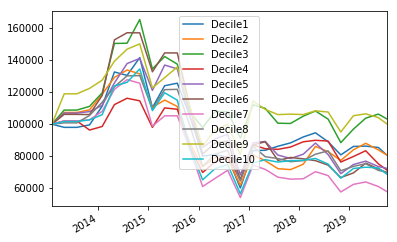

In [130]:
pd.DataFrame(deciles).plot()

In [69]:
lookback = 11
holdPeriod = 3
test = returns.rolling(lookback).apply(multi_period_return)
test = test[lookback:]
mask = test.iloc[0].isnull()
test = test.loc[:,~mask]
print (test)
sorteddf = test.sort_values(by=test.index.values[0], ascending=False, axis=1)
print (sorteddf)

            AdjClose                                                    \
Symbol          1010      1020      1030      1040      1050      1060   
Date                                                                     
2002-12-31  0.197433  0.115895  0.240910  0.094301  0.227000  0.074082   
2003-01-31  0.183522  0.234546  0.367960  0.065033  0.282572  0.152747   
2003-02-28 -0.001608  0.110934  0.105709 -0.041285  0.102588  0.065096   
2003-03-31 -0.096613  0.137429  0.050312 -0.068336 -0.046892  0.010030   
2003-04-30 -0.049172  0.284493  0.040891 -0.009541 -0.020535  0.072637   
2003-05-31  0.016698  0.579839  0.118237  0.016638  0.020955  0.137999   
2003-06-30  0.081844  0.652677  0.133389  0.042916  0.017076  0.153169   
2003-07-31  0.069578  0.811764  0.123213  0.068466  0.057160  0.177173   
2003-08-31  0.149473  0.930043  0.180876  0.054117  0.183258  0.199822   
2003-09-30  0.193677  0.968762  0.289107  0.086894  0.216666  0.214146   
2003-10-31  0.261379  0.859191  0.3008

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:3: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  app.launch_new_instance()


In [81]:
sorteddf = returns.sort_values(by=test.index.values[0], ascending=False, axis=1)
chunks = chunkify(sorteddf, 11)
chunks[0]

AdjClose                                                        \
Symbol          4160      2040      2050      4030          3020      1120   
Date                                                                         
2002-01-31       NaN -0.111416  0.088183 -0.018018  1.001515e-02  0.011382   
2002-12-31  0.078947  0.042723  0.033058  0.027436  2.282688e-02  0.020636   
2003-11-30  0.102273 -0.025510  0.014000  0.002807  2.220446e-16  0.006744   
2004-10-31 -0.044832 -0.028407 -0.035498  0.035704  4.744662e-02  0.136828   
2005-09-30  0.218205  0.112218  0.003605  0.016359 -4.604677e-02  0.014031   
2006-08-31  0.319261  0.036193 -0.034798 -0.068028 -2.504538e-02 -0.010351   
2007-07-31 -0.050507  0.068613  0.030347  0.015875 -2.036334e-02 -0.005222   
2008-06-30 -0.046124  0.060735 -0.019795  0.117395 -2.590030e-02  0.005635   
2009-05-31  0.407304  0.113142  0.058167  0.133045  9.163636e-02  0.134060   
2010-04-30 -0.201544  0.095579  0.027131  0.059914  3.267369e-02  0.045329   
2011-03-31 -0.101323 -0.074208 -0.090299 -0.025783 -1.834615e-02 -0.035358   
2012-02-29  0.199945 -0.031230  0.075457  0.130497  9.642214e-02  0.041526   
2013-01-31  0.082759  0.031748 -0.030269  0.086188  1.397249e-02  0.052246   
2013-12-31  0.131838 -0.052700  0.041366  0.110628 -3.812231e-02 -0.008444   
2014-11-30  0.068903 -0.052804 -0.047877 -0.047993 -2.791567e-02 -0.047653   
2015-10-31  0.079416  0.009428 -0.041276  0.228869 -2.970954e-02 -0.010585   
2016-09-30 -0.122256 -0.096397 -0.037860 -0.097472 -7.668936e-02 -0.026487   
2017-08-31  0.062223 -0.042017  0.001799 -0.085845 -5.614142e-02  0.006342   
2018-07-31 -0.039434 -0.051721 -0.268804  0.011568 -2.138812e-02  0.010912   
2019-06-30  0.002518  0.061122  0.039327  0.018088  4.374690e-02  0.011108   

                                                    ...                      \
Symbol          3040      1020      3010      3060  ...      8240      8250   
Date                                                ...                       
2002-01-31  0.000678  0.044118 -0.000318 -0.009197  ...       NaN       NaN   
2002-12-31  0.017822  0.017534  0.017014  0.015865  ...       NaN       NaN   
2003-11-30 -0.013181  0.003269 -0.014832 -0.000602  ...       NaN       NaN   
2004-10-31  0.000954  0.029589 -0.017936 -0.003735  ...       NaN       NaN   
2005-09-30 -0.066820  0.039298 -0.015960 -0.021014  ...       NaN       NaN   
2006-08-31  0.016629 -0.005081 -0.014565 -0.054005  ...       NaN       NaN   
2007-07-31  0.075015 -0.064010 -0.015203  0.109128  ...       NaN       NaN   
2008-06-30 -0.049962 -0.052323 -0.027351 -0.013552  ...       NaN       NaN   
2009-05-31  0.167758  0.188081  0.169901  0.082903  ...       NaN       NaN   
2010-04-30 -0.009541 -0.028937 -0.034185 -0.021986  ... -0.013507 -0.034793   
2011-03-31  0.008610 -0.035177 -0.051005  0.007561  ... -0.135594 -0.120692   
2012-02-29  0.077203  0.198089  0.074747  0.031516  ...  0.124201  0.086866   
2013-01-31  0.005108  0.062120  0.004212  0.058612  ... -0.305871 -0.102638   
2013-12-31  0.012660  0.042299 -0.054761 -0.050062  ...  0.012565  0.010493   
2014-11-30 -0.023350 -0.030669  0.015120 -0.067938  ... -0.069775 -0.191118   
2015-10-31 -0.039774 -0.041171 -0.042789 -0.045920  ...  0.044889  0.057205   
2016-09-30 -0.081473 -0.061374 -0.040033 -0.054062  ... -0.170529 -0.120508   
2017-08-31 -0.045381  0.033041 -0.066583 -0.052491  ...  0.024826 -0.064113   
2018-07-31 -0.029071  0.027135 -0.073505 -0.029927  ...  0.009529 -0.023407   
2019-06-30  0.118096 -0.015573  0.043400  0.060106  ... -0.031537  0.032641   

                                                                        \
Symbol          8260      8270      8280      8290      8300      8310   
Date                                                                     
2002-01-31       NaN       NaN       NaN       NaN       NaN       NaN   
2002-12-31       NaN       NaN       NaN       NaN       NaN       NaN   
2003-11-30       NaN       Na

In [71]:


chunks = chunkify(sorteddf.T, 6)


In [72]:
chunks[0]

Date             2002-12-31  2003-01-31  2003-02-28  2003-03-31  2003-04-30  \
         Symbol                                                               
AdjClose 6020      1.192963    1.287352    1.053377    0.217694    0.227573   
         4130      0.596780    0.601840    0.527529    0.298158    0.208036   
         4100      0.365856    0.310900    0.064211   -0.004069   -0.001834   
         3010      0.257619    0.318583    0.186423    0.048020    0.080215   
         6030      0.223810    0.238000    0.061581   -0.023199    0.109797   
         6050      0.172742    0.190167    0.021208   -0.058010   -0.059877   
         6090      0.095121    0.115967   -0.095833   -0.282039   -0.167728   
         2080      0.057461    0.091418    0.035271   -0.013613    0.013376   
         2010     -0.028535    0.074632    0.019926   -0.068464   -0.039700   
         1120     -0.104940    0.020313   -0.052822   -0.048100    0.072299   

Date             2003-05-31  2003-06-30  2003-07-31  2003-08-31  2003-09-30  \
         Symbol                                                               
AdjClose 6020      0.374796    0.275408    0.236631    0.270403    0.721179   
         4130      0.486286    0.294709    0.395934    0.375852    0.637546   
         4100      0.047933    0.008407    0.030924    0.073452    0.146842   
         3010      0.187468    0.288692    0.337615    0.349298    0.396794   
         6030      0.179979    0.120805    0.064872    0.034527    0.141905   
         6050      0.002708    0.135777    0.110709    0.152227    0.202878   
         6090     -0.108844   -0.205762   -0.225484    0.026423    0.082005   
         2080      0.183703    0.265151    0.253908    0.315504    0.410229   
         2010      0.054474    0.226481    0.459402    0.939107    1.154143   
         1120      0.124287    0.278868    0.328939    0.443223    0.485028   

Date             ...  2019-01-31  2019-02-28  2019-03-31  2019-04-30  \
         Symbol  ...                                                   
AdjClose 6020    ...   -0.142946   -0.094518   -0.066188   -0.053031   
         4130    ...   -0.010437   -0.028042    0.026758    0.002673   
         4100    ...    0.016389    0.009995    0.019796   -0.033380   
         3010    ...   -0.333005   -0.254374   -0.208902   -0.114160   
         6030    ...         NaN         NaN         NaN         NaN   
         6050    ...    0.184369    0.142632    0.116003    0.124194   
         6090    ...   -0.197525   -0.191922   -0.192806   -0.074631   
         2080    ...    0.002579    0.029482    0.078613    0.117545   
         2010    ...    0.196839    0.158321    0.078903    0.081767   
         1120    ...    0.397809    0.418333    0.297571    0.430571   

Date             2019-05-31  2019-06-30  2019-07-31  2019-08-31  2019-09-30  \
         Symbol                                                               
AdjClose 6020     -0.134552   -0.025248    0.039886    0.055880    0.061873   
         4130     -0.112971    0.008374    0.187161    0.150434    0.062323   
         4100     -0.132439   -0.155981   -0.126500   -0.135241   -0.170998   
         3010     -0.107212    0.005441    0.297730    0.518544   -0.273066   
         6030           NaN         NaN         NaN         NaN         NaN   
         6050      0.023820    0.094425    0.156547    0.284886    0.410004   
         6090     -0.147332   -0.191441   -0.215496   -0.224084   -0.166296   
         2080     -0.018561    0.046243    0.183527    0.180384   -0.351982   
         2010     -0.072140   -0.049427   -0.074917   -0.130009   -0.221283   
         1120      0.297361    0.297614    0.300661    0.166406    0.044240   

Date             2019-10-31  
         Symbol              
AdjClose 6020     -0.000367  
         4130     -0.163225  
         4100     -0.192755  
         3010     -0.319850  
         6030           NaN  
         6050     -0.106056  
         6090     -0.133385  
         2080     

In [73]:
for i in chunks:
    stats(pos_val(df.loc[:,i.T.columns]),'M')

 CAGR(%) = 6.826230191027927
 Sharpe ratio = 0.3666143940473547
 CAGR(%) = 7.1317385468402605
 Sharpe ratio = 0.38124284807910735
 CAGR(%) = 9.023210516087854
 Sharpe ratio = 0.4311152831484829
 CAGR(%) = 7.815926085444436
 Sharpe ratio = 0.40504191819920304
 CAGR(%) = 6.668914945452964
 Sharpe ratio = 0.37931704077642037
 CAGR(%) = 4.967757947438534
 Sharpe ratio = 0.31438599659451


In [74]:
deciles = pd.qcut(sorteddf.iloc[0], 10).values.codes

In [75]:
sorteddfT = sorteddf.T
sorteddfT['deciles'] =  deciles

In [76]:
sorteddfT

Date             2002-12-31 00:00:00  2003-01-31 00:00:00  \
         Symbol                                             
AdjClose 6020               1.192963             1.287352   
         6060               0.982554             1.018824   
         4140               0.877315             0.791042   
         2210               0.659310             0.874276   
         4080               0.644311             0.924953   
         4061               0.621324             0.736850   
         4130               0.596780             0.601840   
         2040               0.507794             0.727183   
         4040               0.471605             0.571010   
         3090               0.439192             0.526838   
         6080               0.400000             0.400000   
         3030               0.394448             0.465500   
         4100               0.365856             0.310900   
         4110               0.338843             0.438203   
         4050               0.334501             0.409876   
         4150               0.332793             0.488546   
         2050               0.318075             0.391721   
         6040               0.280752             0.324583   
         3010               0.257619             0.318583   
         2130               0.252643             0.343407   
         2090               0.240973             0.386384   
         1030               0.240910             0.367960   
         3060               0.230694             0.373875   
         1050               0.227000             0.282572   
         6030               0.223810             0.238000   
         6070               0.223008             0.223221   
         2170               0.211640             0.339069   
         2120               0.199074             0.246083   
         1010               0.197433             0.183522   
         1080               0.179991             0.175751   
         6050               0.172742             0.190167   
         2150               0.146667             0.288889   
         2060               0.144201             0.236405   
         4020               0.142740             0.171033   
         3050               0.131331             0.234830   
         1020               0.115895             0.234546   
         6090               0.095121             0.115967   
         1040               0.094301             0.065033   
         1060               0.074082             0.152747   
         3020               0.068662             0.112408   
         2070               0.060498             0.117118   
         3040               0.058833             0.086791   
         2080               0.057461             0.091418   
         4090               0.039548             0.124126   
         6010               0.004808             0.070475   
         4010               0.002250             0.046917   
         2160              -0.010816             0.018745   
         3080              -0.011325             0.045404   
         2010              -0.028535             0.074632   
         2110              -0.029567             0.026187   
         4030              -0.041940            -0.036177   
         4070              -0.072404            -0.013291   
         4170              -0.075706            -0.053664   
         2140              -0.082015             0.004687   
         1120              -0.104940             0.020313   
         2100              -0.120301            -0.088889   
         1090              -0.184527            -0.144134   
         2020              -0.199389            -0.118657   

Date             2003-02-28 00:00:00  2003-03-31 00:00:00  \
         Symbol                                             
AdjClose 6020               1.053377             0.217694   
         6060               0.586394            -0.005270   
         4140               0.639320             0.518288   
         2210               0.5315

In [77]:
sorteddfT.groupby('deciles')